In [1]:
import pandas as pd
import random
import time
import os
import imp
import cv2
import pickle
import shutil
import numpy as np
from utils import OD_Assemble
import tensorflow as tf
from tqdm import tqdm
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from tensorflow.keras.preprocessing.image import img_to_array,load_img

# optional
# from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../annotations/csvs/uncropped_res_capped_balanced/test.csv')
PATH_TO_LABELS = "../annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

# MODEL_LIST = ['faster_rcnn_resnet101_v1_640x640_BBOX.pkl','ssd_resnet152_v1_fpn_640x640.pkl','centernet_resnet101_v1_512x512_BBOX.pkl']
MODEL_LIST = os.listdir('../annotations/ensemble_outputs/single_model_preds')
predictions_dict = {}
for i in range(len(MODEL_LIST)):
    with open('../annotations/ensemble_outputs/single_model_preds/'+MODEL_LIST[i], 'rb') as f:
        predictions_dict[i] = pickle.load(f)

In [3]:
def show_inference(frame,location=0,model=0):
    
    prediction = predictions_dict[model][location]
    test_image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)
    test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
    test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.
    
    prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)
    image_with_detections = test_image_rgb.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_with_detections,
            prediction['detection_boxes'],
            prediction['detection_classes'],
            prediction['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=0.5,
            agnostic_mode=False)
    return image_with_detections

In [4]:
MODEL_LIST

['centernet_resnet101_v1_512x512_BBOX.pkl',
 'faster_rcnn_inception_resnet_v2_640x640_BBOX.pkl',
 'faster_rcnn_resnet101_v1_1024x1024_BBOX.pkl',
 'faster_rcnn_resnet101_v1_640x640_BBOX.pkl',
 'faster_rcnn_resnet152_v1_640x640_BBOX.pkl',
 'faster_rcnn_resnet152_v1_800x1333_BBOX.pkl',
 'faster_rcnn_resnet50_v1_640x640_BBOX.pkl',
 'ssd_resnet152_v1_fpn_640x640.pkl']

In [5]:
imp.reload(OD_Assemble)
nmodels = [2,3,4,5,6]
combine = OD_Assemble.NCombiner(indexes=nmodels,con_thresh=0.5,iou_thresh=0.6)

<Figure size 4320x3456 with 0 Axes>

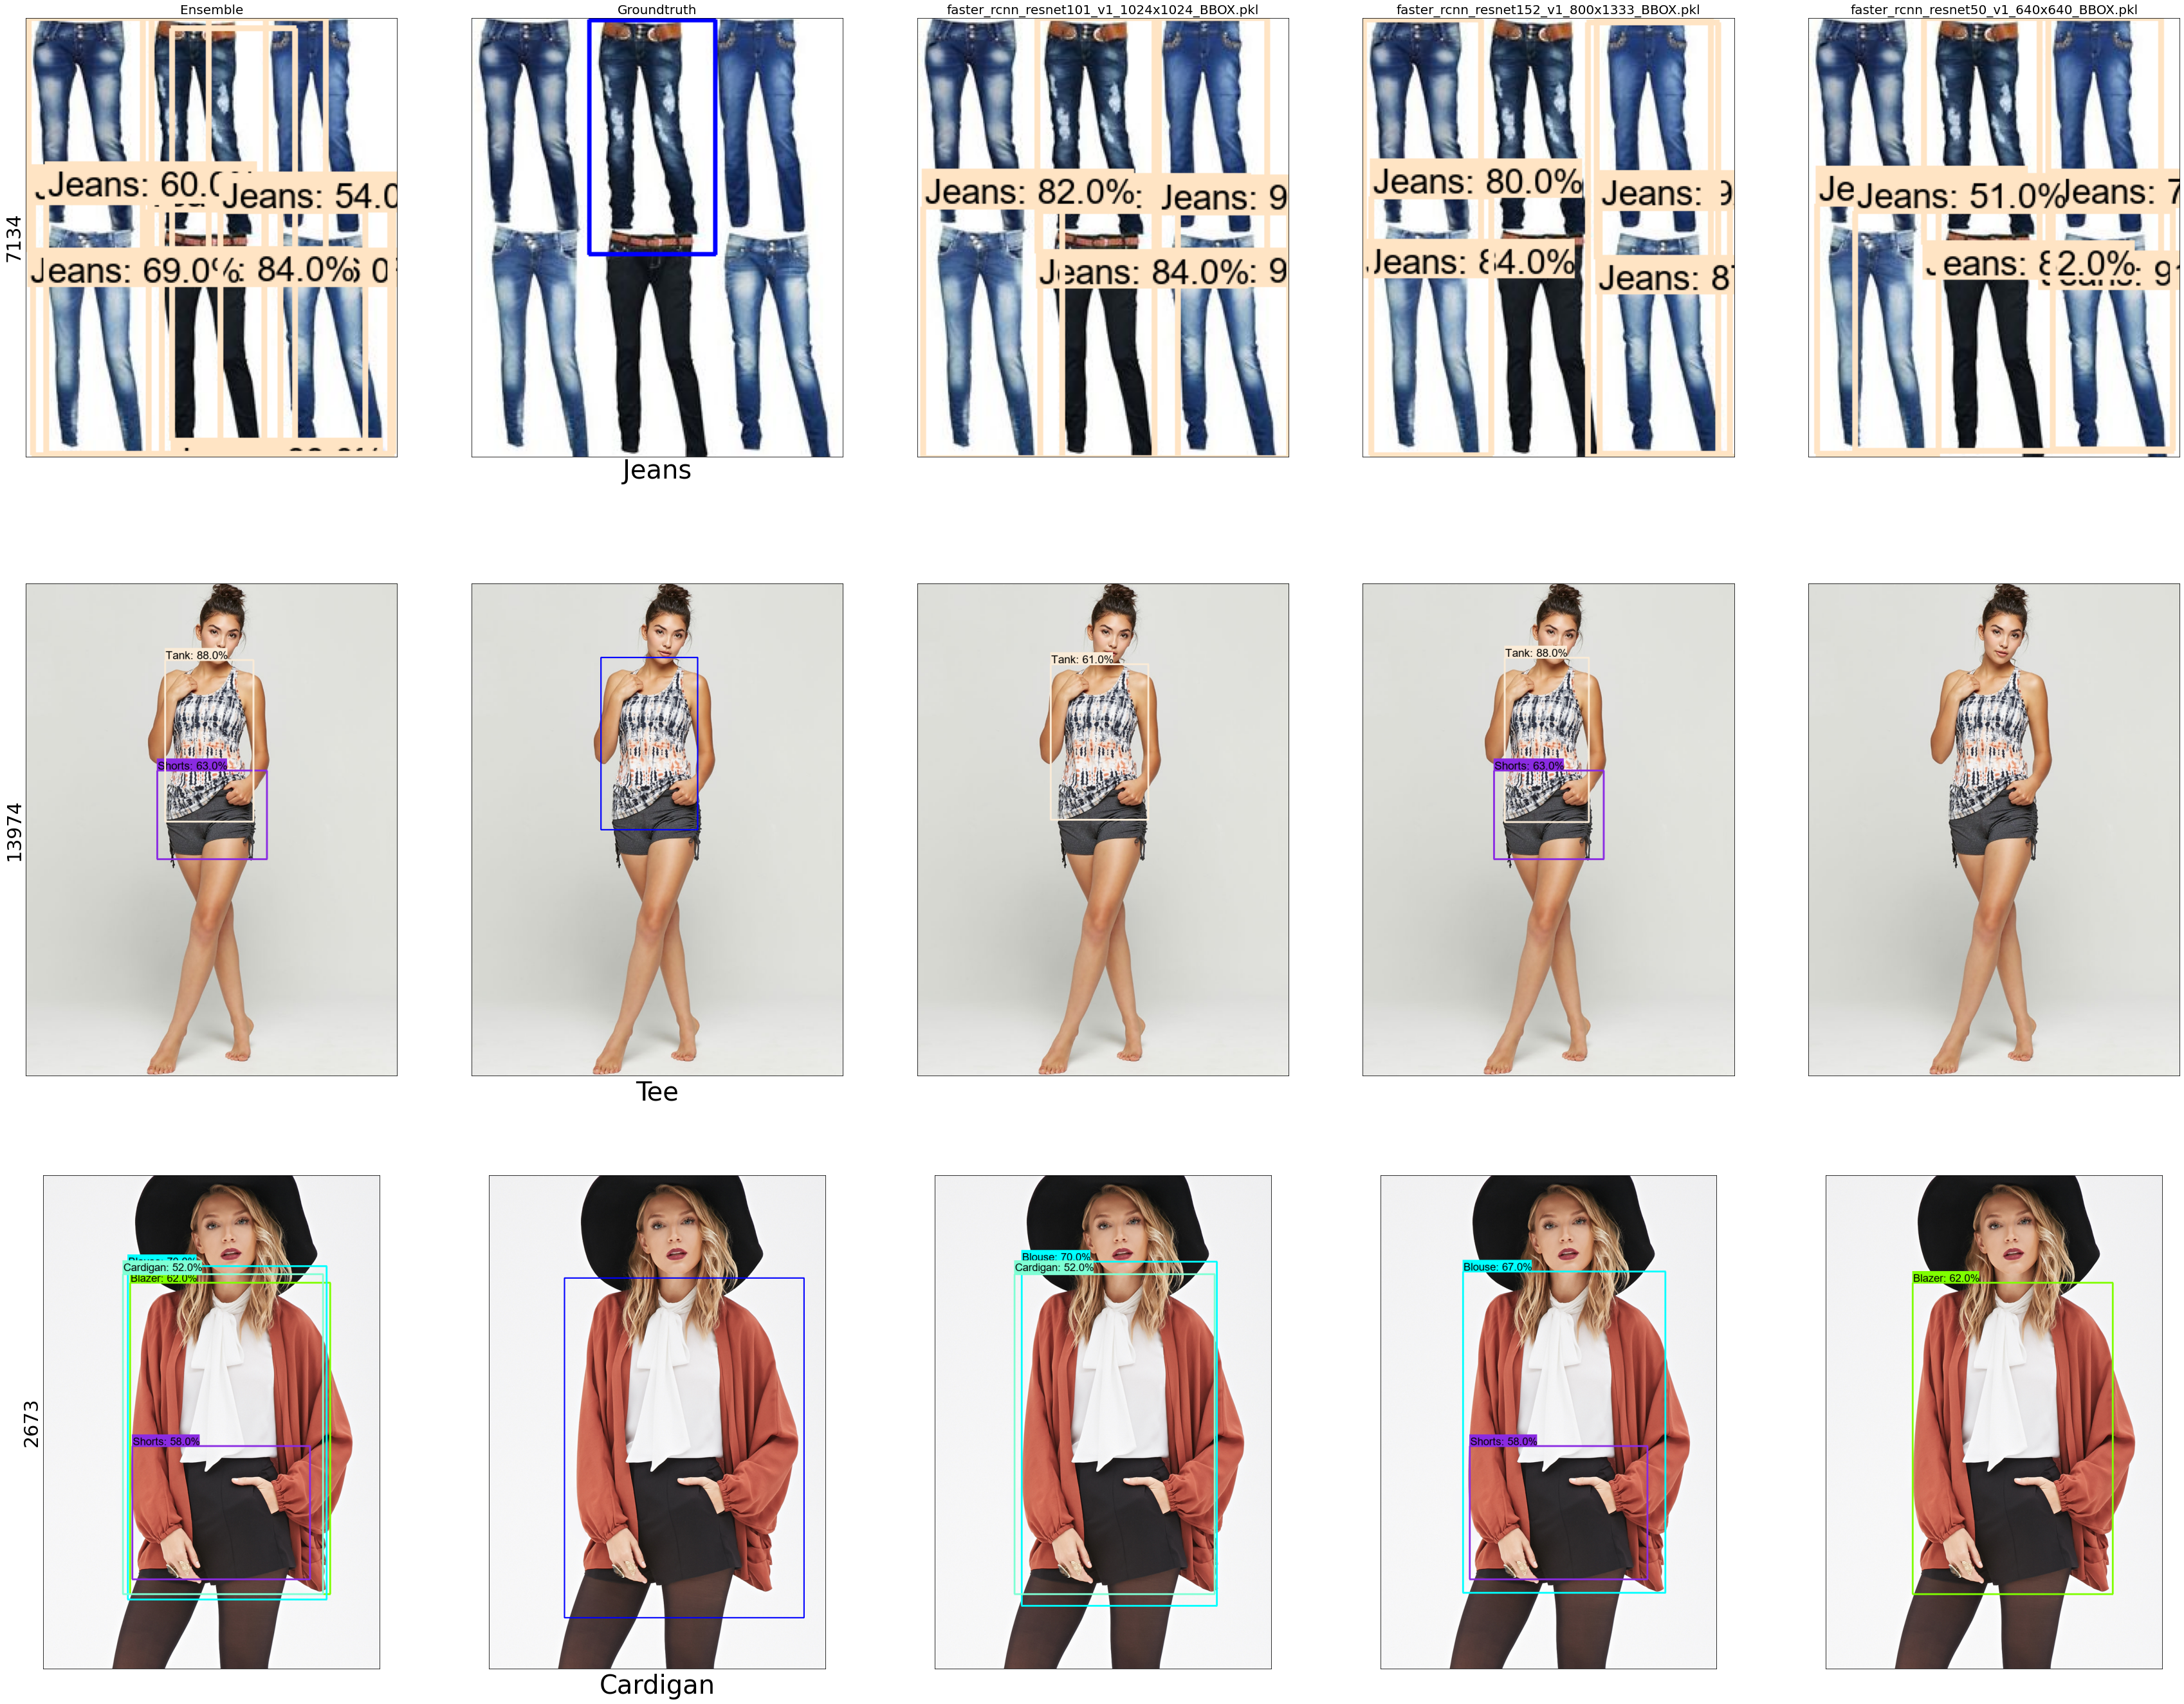

In [15]:
# samples = 5
# sams = random.sample(range(15600),samples)
# sams = [8547,9705,14619,14150]
# sams = [6925,6645,10923]
# sams = [14177,3320,13959]
# sams = [8547,9705,14619,14150,6925,6645,10923,13959]
# sams = [14177,13959]
# sams = [14150,13959]
# sams = [12113,6877,8979,7134,13974,2673]
sams = [7134,13974,2673]
samples = len(sams)


plt.figure(figsize=(20*len(nmodels),16*samples))

cols = ['Ensemble','Groundtruth']
cols.extend([MODEL_LIST[mdl] for mdl in nmodels])
rows = sams

fig, axes = plt.subplots(nrows=samples, ncols=len(nmodels)+2, figsize=(20*len(nmodels),16*samples))
# fig.patch.set_facecolor('white')

for ax, col in zip(axes[0], cols):
    ax.set_title(col,fontdict={'fontsize': 20,'color':'black'})

for ax, row in zip(axes[:,0], rows):
    # print(row)
    ax.set_ylabel(row, fontsize=30,color='black')

for i in range(len(sams)):
    loc = sams[i]
    d = df.iloc[loc]
    test_image_o = cv2.imread('../'+d['filename'])
    
    axs = axes[i][0]
    image_with_detections = combine.Wfb(location=loc,operator=2,visualize=1)
    axs.imshow(image_with_detections)
    axs.set_yticks([])
    axs.set_xticks([])
    
    img_copy = test_image_o.copy()
    x1,y1,x2,y2 = d[['xmin','ymin','xmax','ymax']].values
    grndimg = cv2.rectangle(img_copy,(x1,y1),(x2,y2),(255, 0, 0), 2)
    
    axs = axes[i][1]
    axs.imshow(cv2.cvtColor(grndimg, cv2.COLOR_BGR2RGB))
    axs.text(0.5,-0.05, d['class'], size=40, color='black', ha="center",transform=axs.transAxes)
    axs.set_yticks([])
    axs.set_xticks([])
    
    for j in range(len(nmodels)):
        axs = axes[i][j+2]
        modl = nmodels[j]
        inference = show_inference(test_image_o,loc,modl)
        axs.imshow(inference)
        axs.set_yticks([])
        axs.set_xticks([])
plt.savefig('outputs/report/output_'+str(int(time.time()))+'.png', bbox_inches='tight',dpi=400,facecolor=fig.get_facecolor())
plt.show()

In [7]:
# imp.reload(OD_Assemble)
# nmodels = [2,3,4,5]
# combine = OD_Assemble.NCombiner(indexes=nmodels,con_thresh=0.5,iou_thresh=0.55)


In [ ]:
# fname = 'test imgs/aishwarya-full.jpeg'
# image_with_detections = combine.Wfb(location=101,operator=2,visualize=1,filename = fname)
# plt.imshow(image_with_detections)